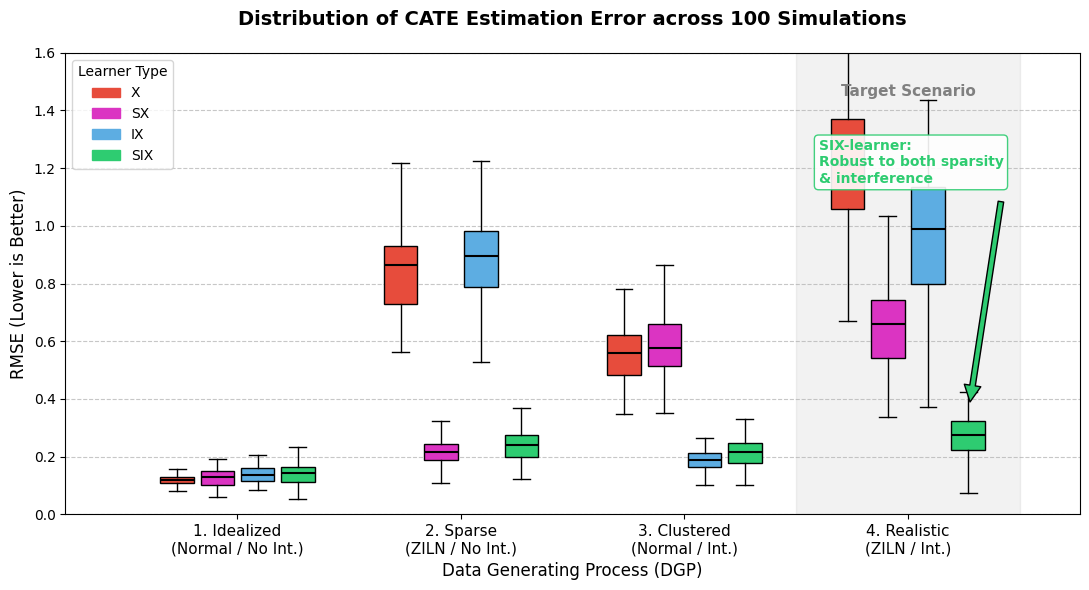

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# --- 1. Generate Dummy Data ---
np.random.seed(42)
n_simulations = 100 

def generate_errors(mean, std, n=n_simulations):
    # Ensure errors are positive (RMSE)
    return np.abs(np.random.normal(mean, std, n))

# Define the 4 Scenarios (DGPs)
# Format: { 'ModelName': (mean, std) }
scenarios_config = {
    '1. Idealized\n(Normal / No Int.)': {
        'X': (0.12, 0.02), 'SX': (0.13, 0.03), 'IX': (0.13, 0.03), 'SIX': (0.14, 0.04)
    },
    '2. Sparse\n(ZILN / No Int.)': {
        'X': (0.85, 0.15), 'SX': (0.22, 0.05), 'IX': (0.88, 0.16), 'SIX': (0.24, 0.06)
    },
    '3. Clustered\n(Normal / Int.)': {
        'X': (0.55, 0.10), 'SX': (0.58, 0.11), 'IX': (0.18, 0.04), 'SIX': (0.20, 0.05)
    },
    '4. Realistic\n(ZILN / Int.)': {
        'X': (1.20, 0.25), 'SX': (0.65, 0.15), 'IX': (0.95, 0.20), 'SIX': (0.28, 0.07)
    }
}

# Extract scenario names and model names
scenario_names = list(scenarios_config.keys())
models = ['X', 'SX', 'IX', 'SIX']
colors = ['#e74c3c', "#db34c2", '#5dade2', '#2ecc71'] # Red, Blue, Light Blue, Green

# Prepare data for plotting
# structure: data_by_model[model_index] = [ [data_dgp1], [data_dgp2], ... ]
data_by_model = []
for model in models:
    model_data = []
    for dgp in scenario_names:
        params = scenarios_config[dgp][model]
        model_data.append(generate_errors(params[0], params[1]))
    data_by_model.append(model_data)

# --- 2. Plotting Logic ---
fig, ax = plt.subplots(figsize=(11, 6))

# Define positions
num_groups = len(scenario_names)
num_models = len(models)
bar_width = 0.15
# Calculate group centers (e.g., 1, 2, 3, 4)
indices = np.arange(num_groups)

# Plot each model's boxplots at offset positions
for i, (model_name, color) in enumerate(zip(models, colors)):
    # Calculate positions for this model across all groups
    # Center the group of 4 bars around the index
    positions = indices + (i - (num_models - 1) / 2) * bar_width * 1.2
    
    # Create the boxplot
    bp = ax.boxplot(data_by_model[i], positions=positions, widths=bar_width, 
                    patch_artist=True, showfliers=False)
    
    # Style the boxplot elements
    for patch in bp['boxes']:
        patch.set_facecolor(color)
        patch.set_linewidth(1.0)
    for element in ['whiskers', 'caps', 'medians']:
        plt.setp(bp[element], color='black', linewidth=1.0)
    plt.setp(bp['medians'], linewidth=1.5)

# --- 3. Styling & Annotations ---

# Axes Labels and Ticks
ax.set_xticks(indices)
ax.set_xticklabels(scenario_names, fontsize=11)
ax.set_ylabel('RMSE (Lower is Better)', fontsize=12)
ax.set_xlabel('Data Generating Process (DGP)', fontsize=12)
ax.set_title('Distribution of CATE Estimation Error across 100 Simulations', 
             fontsize=14, fontweight='bold', pad=20)

# Set Y-limit to make room for top labels
ax.set_ylim(0, 1.6)

# Grid
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.xaxis.grid(False)

# Custom Legend
legend_patches = [mpatches.Patch(color=c, label=m) for c, m in zip(colors, models)]
ax.legend(handles=legend_patches, title='Learner Type', loc='upper left')

# Highlight "Realistic" Scenario (Shading)
# The last group is at index 3. We shade around it.
ax.axvspan(2.5, 3.5, color='gray', alpha=0.1, zorder=0)
ax.text(3, 1.45, "Target Scenario", ha='center', fontsize=11, color='gray', fontweight='bold')

# Annotation for SIX-learner
# Coordinates: Group 3 (Realistic), Model 3 (SIX) is at the far right of the group
arrow_x = 3 + (3 - 1.5) * bar_width * 1.2 # Approx position of the green box
ax.annotate('SIX-learner:\nRobust to both sparsity\n& interference', 
            xy=(arrow_x, 0.35), xytext=(2.6, 1.15),
            arrowprops=dict(facecolor='#2ecc71', shrink=0.05),
            fontsize=10, fontweight='bold', color='#2ecc71',
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="#2ecc71", alpha=0.9))

plt.tight_layout()

# Save and Show
plt.savefig('cate_rmse_boxplot_matplotlib.png', dpi=300)
plt.show()

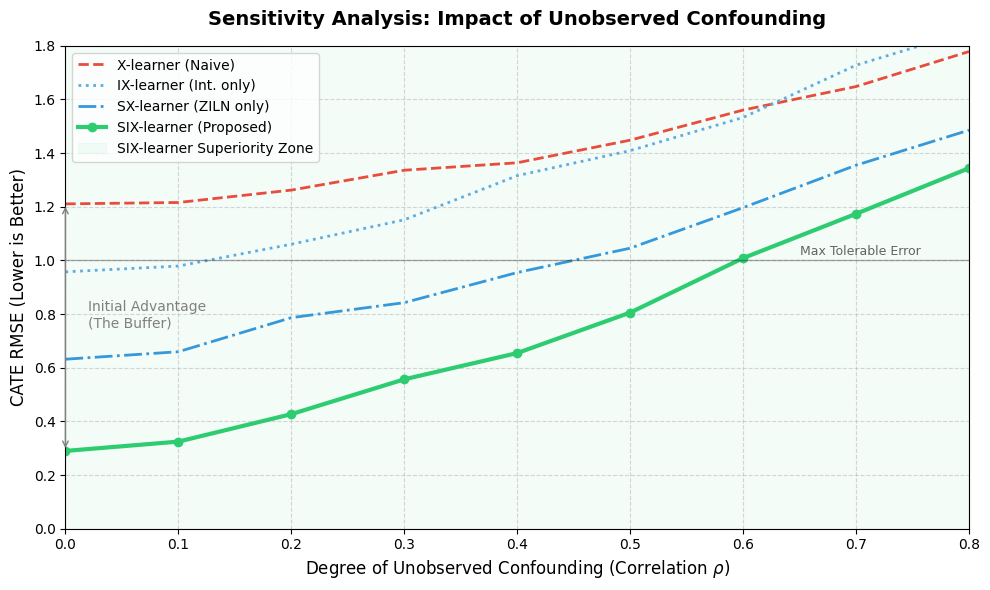

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Generate Dummy Sensitivity Data ---
np.random.seed(42)
confounding_levels = np.linspace(0, 0.8, 9) # 0.0 to 0.8

# Hypothesis:
# 1. X-learner starts bad (high RMSE) and gets worse.
# 2. SIX-learner starts good (low RMSE) and gets worse.
# 3. Eventually, confounding overwhelms everything, and they might converge or cross.

# Base RMSE at rho=0 (Taken from previous "Realistic" scenario)
base_rmse_six = 0.28
base_rmse_x = 1.20
base_rmse_sx = 0.65
base_rmse_ix = 0.95

# Degradation function: Error increases as confounding (rho) increases
def degrade(base, rho, sensitivity):
    noise = np.random.normal(0, 0.02, len(rho))
    # Non-linear degradation (confounding bias squares)
    return base + (sensitivity * rho**1.5) + noise 

rmse_six = degrade(base_rmse_six, confounding_levels, sensitivity=1.5)
rmse_x = degrade(base_rmse_x, confounding_levels, sensitivity=0.8) # Starts high, grows slower?
rmse_sx = degrade(base_rmse_sx, confounding_levels, sensitivity=1.2)
rmse_ix = degrade(base_rmse_ix, confounding_levels, sensitivity=1.3)

# --- 2. Plotting ---
plt.figure(figsize=(10, 6))

# Plot lines
plt.plot(confounding_levels, rmse_x, label='X-learner (Naive)', color='#e74c3c', linewidth=2, linestyle='--')
plt.plot(confounding_levels, rmse_ix, label='IX-learner (Int. only)', color='#5dade2', linewidth=2, linestyle=':')
plt.plot(confounding_levels, rmse_sx, label='SX-learner (ZILN only)', color='#3498db', linewidth=2, linestyle='-.')
plt.plot(confounding_levels, rmse_six, label='SIX-learner (Proposed)', color='#2ecc71', linewidth=3, marker='o')

# --- 3. Annotations for Insight ---

# A. The "Performance Buffer"
plt.annotate('', xy=(0, rmse_six[0]), xytext=(0, rmse_x[0]),
             arrowprops=dict(arrowstyle='<->', color='gray'))
plt.text(0.02, (rmse_six[0] + rmse_x[0])/2, 'Initial Advantage\n(The Buffer)', fontsize=10, color='gray')

# B. The "Break-Even" or "Robustness Zone"
# We shade the region where SIX is still the best
plt.fill_between(confounding_levels, 0, 2.0, where=(rmse_six < rmse_x), 
                 color='#2ecc71', alpha=0.05, label='SIX-learner Superiority Zone')

# C. Threshold Line (Optional - e.g. "Unacceptable Error")
plt.axhline(y=1.0, color='black', linewidth=1, alpha=0.3)
plt.text(0.65, 1.02, 'Max Tolerable Error', fontsize=9, alpha=0.6)

# Styling
plt.title('Sensitivity Analysis: Impact of Unobserved Confounding', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Degree of Unobserved Confounding (Correlation $\\rho$)', fontsize=12)
plt.ylabel('CATE RMSE (Lower is Better)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.ylim(0, 1.8)
plt.xlim(0, 0.8)

plt.tight_layout()
plt.savefig('sensitivity_analysis_confounding.png', dpi=300)
plt.show()